In [1]:
## Import stuff
#import datetime
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime


# Define function to plot 1 axis
def one_axis(f, url, threshold):
    def ionosonde_plotter(f):
        # Define timestamp array
        timestamp_full = []

        # Minimum virtual height of E trace
        hE = []
        timestamp_hE = []
        # Minimum virtual height of Es trace
        hEs = []
        timestamp_hEs = []

        # Define CS array
        CS = []

        # E layer critical frequency
        foE =[]
        timestamp_foE = []
        # Es layer critical frequency
        foEs = []
        timestamp_foEs = []


        # Define filename
        filename = f + ".txt"

        # define indices for each parameter of file
        time_idx = 0
        CS_idx = 1
        foEs_idx = 2
        foE_idx = 4
        hE_idx = 6
        hEs_idx = 8

        # Define format for datetime
        format = "%Y-%m-%dT%H:%M:%S.%fZ"

        # Open file - read
        fp = open(filename, 'r')
        # Read every line in file
        for line in fp:
        # Skip comments
            if line[0] == "#":
                continue
        # Strip lines
            else:
                line_strip = line.strip()
        # Split lines into lists
                line_split = line.split()

                foE_str = line_split[foE_idx]
                foEs_str = line_split[foEs_idx]
                hE_str = line_split[hE_idx]
                hEs_str = line_split[hEs_idx]

                timestamp_full.append(datetime.datetime.strptime(line_split[time_idx], format))

                # Check if can convert foE to float
                try:
                    foE_float = float(foE_str)
                    # If successful, append to the array
                    foE.append(foE_float)
                    # Extract timestamp and append to the array
                    timestamp_str = line_split[time_idx]
                    timestamp_foE.append(datetime.datetime.strptime(timestamp_str, format))
                except ValueError:
                    # If the conversion fails, ignore the line
                    pass

                # Check if can convert foEs to float
                try:
                    foEs_float = float(foEs_str)
                    # If successful, append to the array
                    foEs.append(foEs_float)
                    # Extract timestamp and append to the array
                    timestamp_str = line_split[time_idx]
                    timestamp_foEs.append(datetime.datetime.strptime(timestamp_str, format))
                except ValueError:
                    # If the conversion fails, ignore the line
                    pass

                # Check if hE can convert to float
                try:
                    hE_float = float(hE_str)
                    # If successful, append to the array
                    hE.append(hE_float)
                    # Extract timestamp and append to the array
                    timestamp_strhE = line_split[time_idx]
                    timestamp_hE.append(datetime.datetime.strptime(timestamp_strhE, format))
                except ValueError:
                    # If the conversion fails, ignore the line
                    pass

                # Check if hEs can convert to float
                try:
                    hEs_float = float(hEs_str)
                    # If successful, append to the array
                    hEs.append(hEs_float)
                    # Extract timestamp and append to the array
                    timestamp_strhEs = line_split[time_idx]
                    timestamp_hEs.append(datetime.datetime.strptime(timestamp_strhEs, format))
                except ValueError:
                    # If the conversion fails, ignore the line
                    pass

        return timestamp_foEs, foEs, timestamp_hEs, hEs
    
    # define riometer readfile function
    def rio_readfile(url):

        # Define lists
        #date = [] #do i even need the date cause it's the same year?
        time = []
        absorption = []
        raw_sig = []

        # Define filename
        #filename = "RD 2012-03-03.txt"

        # open file to read
        response = urllib.request.urlopen(url)
        html_response = response.read()
        encoding = response.headers.get_content_charset("utf-8")
        fp = html_response.decode(encoding)

        # define new list sanitized_data
        # entry = [] list defined later, append datetime, absp, raw sig to it
        # later append entry to sanitized_data so it will be lists within a list
        sanitized_data = []

        for line in fp.splitlines():
            #print(line)
            #print(str(line))

            # skip comments
            if line[0] == "#":
                continue
            else:

                # strip line
                line_strip = line.strip()
                # split lines into lists
                line_split = line.split()
                #print(line_split[1])

                # Define datetime format for date and time

                format = "%d%m%Y%H:%M:%S"

                # split column 0 to month, date, year and make one row
                month = str(line_split[0].split("/")[1])
                day = str(line_split[0].split("/")[0])
                year = "20" + str(line_split[0].split("/")[2])

                # change this to dd mm yy!!!!!!!!!!!
                full_date = day + month + year + str(line_split[1])

                # Try-except to see if can convert to datetime
                try:
                    res = bool(datetime.datetime.strptime(full_date, format))
                    this_time = datetime.datetime.strptime(full_date, format)

                    # Get rid of negative absorption values
                    if float(line_split[2]) < 0:
                        continue
                    # append time to array
                    time.append(this_time)
                    # append absorption to array
                    absorption.append(float(line_split[2]))
                    # append raw signals to array
                    raw_sig.append(line_split[3])

                    # define new list 
                    entry = []
                    entry.append(this_time)
                    entry.append(line_split[2])
                    entry.append(line_split[3])

                    sanitized_data.append(entry)

                except ValueError:
                    res = False

        #return sanitized_data
        return sanitized_data, time, absorption, raw_sig
        #return absorption
        #return raw_sig
    
    # To get the correct riometer graph
    def filter_spikes(ax, times, absorptions, threshold, neighbor_count=10):
        """
        Filter out absorption spikes where the value is greater than a threshold relative to the average of its neighbors.
        """
        filtered_times = []
        filtered_absorptions = []

        for i in range(len(absorptions)):
            # Determine the range for neighbors
            start_index = max(i - neighbor_count, 0)
            end_index = min(i + neighbor_count + 1, len(absorptions))

            # Calculate the average of neighboring values
            neighbor_avg = sum(absorptions[start_index:end_index]) / (end_index - start_index)

            # Check if the current value is within the threshold relative to the neighbor average
            if abs(absorptions[i] - neighbor_avg) <= threshold:
                filtered_times.append(times[i])
                filtered_absorptions.append(absorptions[i])

        # Plot on the provided axis
        ax.plot(filtered_times, filtered_absorptions, color='darkolivegreen', label="Absorption", linestyle = "-")
        #ax.set_title("03/03/2012 Riometer absorption (dB) vs time (UTC H:M:S) with threshold 0.06")
        ax.set_xlabel("Time (UTC) H:M:S", fontsize=14)
        ax.tick_params(axis='x', rotation=90)
        ax.set_ylabel("Absorption (dB)", fontsize=14)

    sanitized_data, time, absorption, raw_sig = rio_readfile(url)
    
    timestamp_foEs, foEs, timestamp_hEs, hEs = ionosonde_plotter(f)
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

    # Plot foEs on the first subplot
    foEs_plot = ax1.scatter(timestamp_foEs, foEs, label='foEs: Sporadic E layer \ncritical frequency', color='midnightblue', s=8)
    ax1.set_ylabel('foEs (MHz)', color='black', labelpad = 15, fontdict={'family': 'serif', 'size': 12}) # labelpad aligns all y labels
    ax1.tick_params('y', colors='black')
    legend1 = ax1.legend(handles=[foEs_plot], loc='best', prop={'family': 'serif', 'size': 12})
    legend1.get_frame().set_alpha(0.25)
    #ax1.legend(prop={'family': 'serif', 'size': 12})
   

    # Plot hEs on the second subplot
    hEs_plot = ax2.scatter(timestamp_hEs, hEs, label='hEs: Sporadic E layer height', color='maroon', s=8)
    ax2.set_ylabel('hEs (KM)', color='black', fontdict={'family': 'serif', 'size': 12})
    ax2.tick_params('y', colors='black')
    #ax2.legend(prop={'family': 'serif', 'size': 12})
    legend2 = ax2.legend(handles=[hEs_plot], loc='best', prop={'family': 'serif', 'size': 12})
    legend2.get_frame().set_alpha(0.25)

    # Plot absorption on the third subplot
    absorption_plot = filter_spikes(ax3, time, absorption, threshold, neighbor_count=10)
    ax3.set_ylabel('Absorption (dB)', color='black', labelpad = 14, fontdict={'family': 'serif', 'size': 12}) # labelpad aligns all y labels
    ax3.tick_params('y', colors='black')
    ax3.legend(prop={'family': 'serif', 'size': 12}, facecolor='darkolivegreen',framealpha=0.25)

    legend1.get_frame().set_facecolor(foEs_plot.get_facecolor())
    legend2.get_frame().set_facecolor(hEs_plot.get_facecolor())
     
    # Format x-axis labels to show only HH:MM
    date_formatter = mdates.DateFormatter('%H:%M')
    plt.gca().xaxis.set_major_formatter(date_formatter)

    # Set common x-axis label and title
    plt.xlabel('Time (HH:MM)', fontdict={'family': 'serif', 'size': 11}, labelpad = 20)
    #plt.suptitle("foEs (MHz), hEs (KM), and Absorption (dB) vs Time (HH:MM) for One Day of Data (03/03/2012)", y=1)

    #linesplit f
    title_date = f.split("-")
    #title
    #title_header = "{year}-{month}-{day}(yyyy-mm-dd) - foEs, hEs, and riometer absorption (with threshold={threshold}) on a single time axis".format(year=title_date[0], month=title_date[1], day=title_date[2], threshold=threshold)

    #plt.suptitle(title_header, fontsize=16, y=0.98)  # Title added here
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some space at the top for the title

    # save figure
    plt.savefig("one_axis_{date}_presentation.jpg".format(date=f), bbox_inches="tight")  # Specify dpi for better resolution

    # Display the plot
    plt.show()
    

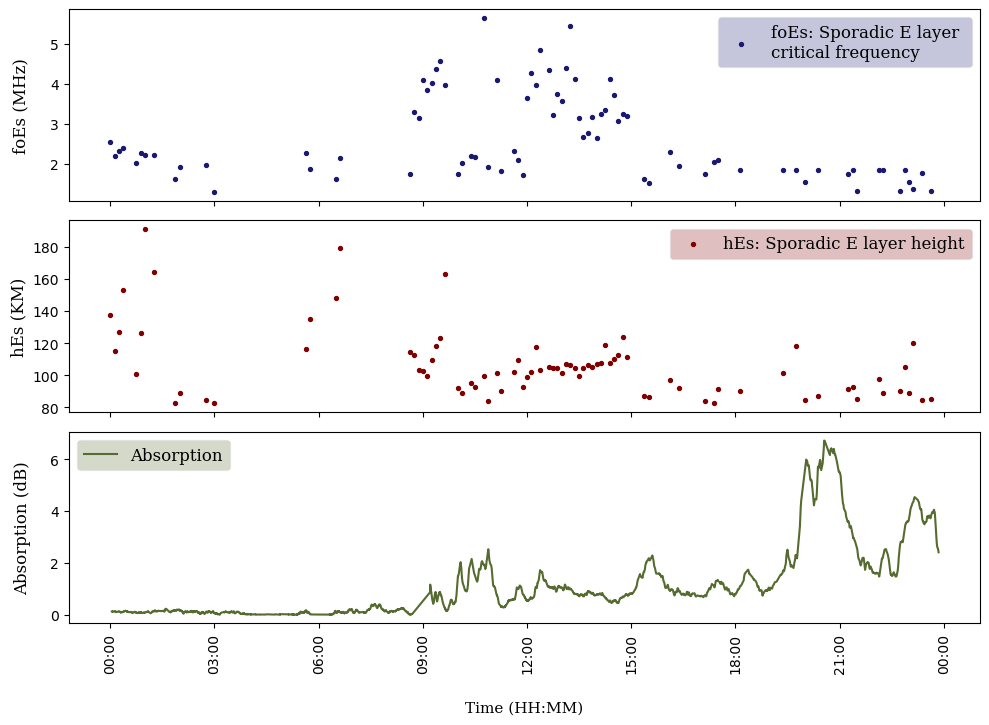

In [2]:
year_str = "2012"
month_str = "03"
day_str = "01"

one_axis("{year}-{month}-{day}".format(year=year_str, month=month_str, day=day_str), "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/{year}/{month}/{day}/norstar_k2_rio-daws_{year}{month}{day}_v01.txt".format(year=year_str, month=month_str, day=day_str), threshold=0.01)


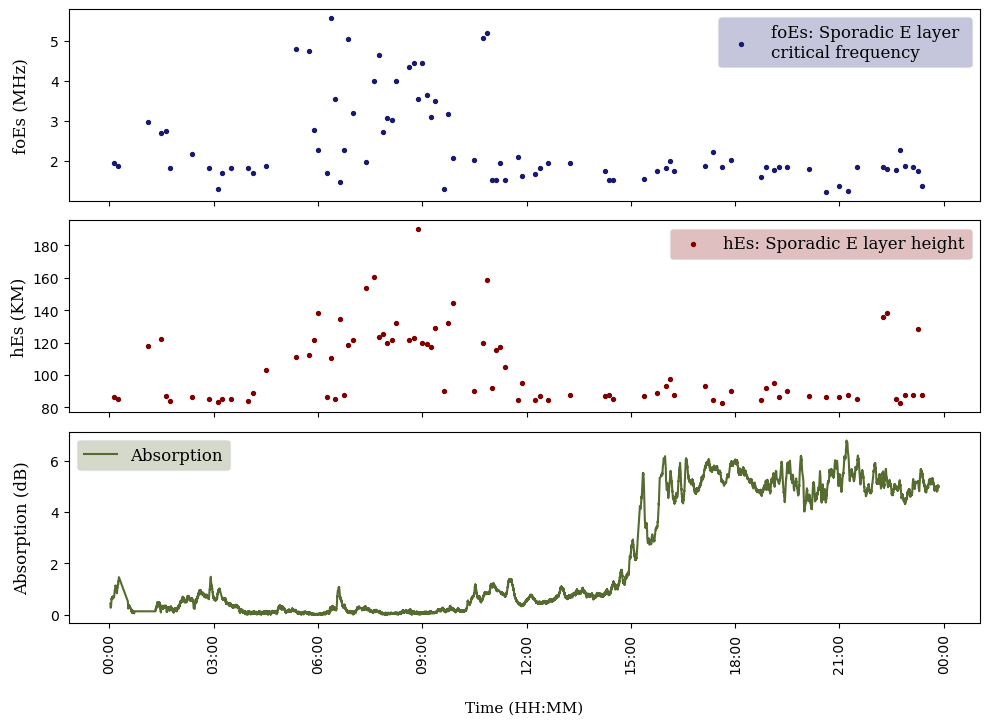

In [3]:
year_str = "2012"
month_str = "03"
day_str = "07"

one_axis("{year}-{month}-{day}".format(year=year_str, month=month_str, day=day_str), "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/{year}/{month}/{day}/norstar_k2_rio-daws_{year}{month}{day}_v01.txt".format(year=year_str, month=month_str, day=day_str), threshold=0.06)


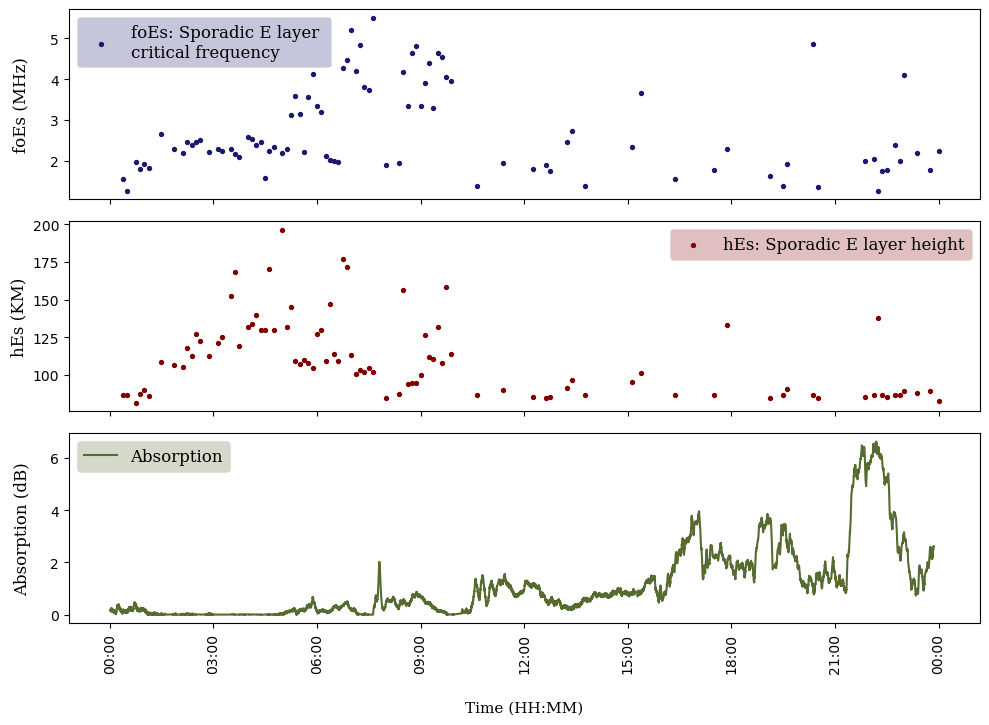

In [4]:
year_str = "2012"
month_str = "04"
day_str = "25"

one_axis("{year}-{month}-{day}".format(year=year_str, month=month_str, day=day_str), "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/{year}/{month}/{day}/norstar_k2_rio-daws_{year}{month}{day}_v01.txt".format(year=year_str, month=month_str, day=day_str), threshold=0.06)


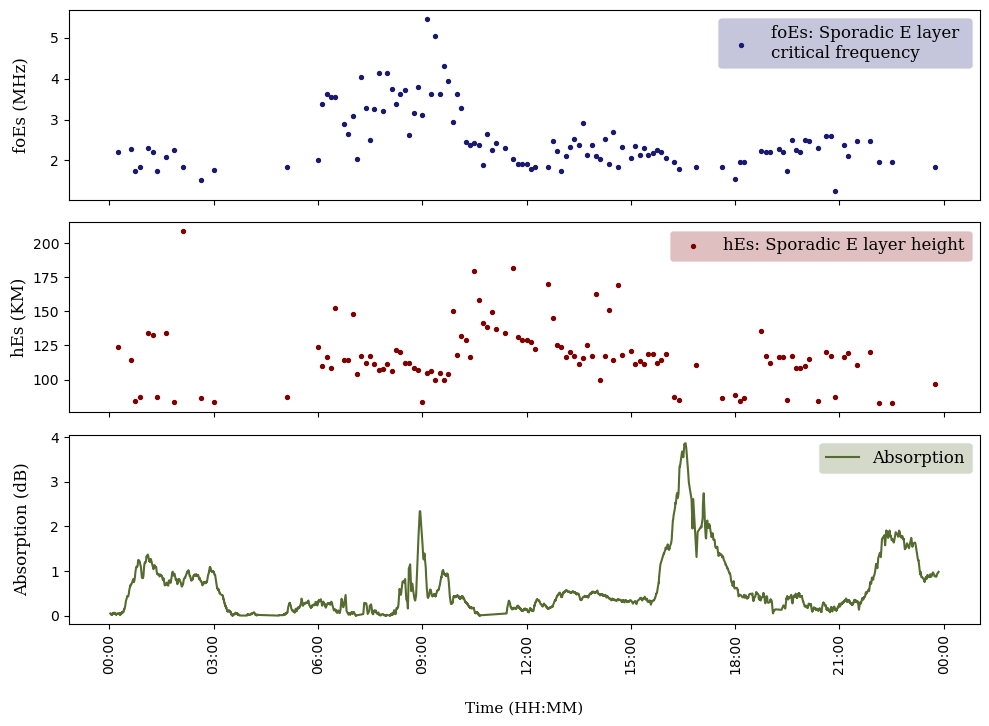

In [5]:
year_str = "2012"
month_str = "03"
day_str = "03"

one_axis("{year}-{month}-{day}".format(year=year_str, month=month_str, day=day_str), "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/{year}/{month}/{day}/norstar_k2_rio-daws_{year}{month}{day}_v01.txt".format(year=year_str, month=month_str, day=day_str), threshold=0.01)
